In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Stock Dataset

In [20]:
# APPLE stock data from 2006-07-18 to 2020-07-18
data = pd.read_csv('./AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-07-17,7.390000,7.587143,7.378572,7.481429,6.476653,256135600
1,2006-07-18,7.594285,7.692857,7.407143,7.557143,6.542199,250112100
2,2006-07-19,7.565714,7.868571,7.480000,7.728571,6.690604,347685800
3,2006-07-20,8.708571,8.798572,8.531428,8.642858,7.482098,493036600
4,2006-07-21,8.545714,8.735714,8.520000,8.674286,7.509306,222973100


In [21]:
# this many entries
len(data['Date'])

3525

# Plot Data

In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time since 2006-07-18")
    plt.ylabel("Closing Price")
    plt.grid(True)

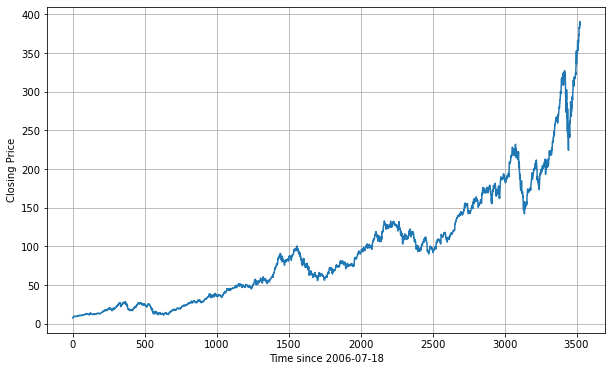

In [23]:
series = np.array(data['Close'])
time = range(len(data['Date']))
plt.figure(figsize=(10,6))
plot_series(time, series)

# Split Data

In [25]:
split_time = 3000
# use 3000 days for training and about 500 for testing
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size= 30
batch_size = 32
shuffle_buffer_size = 1000

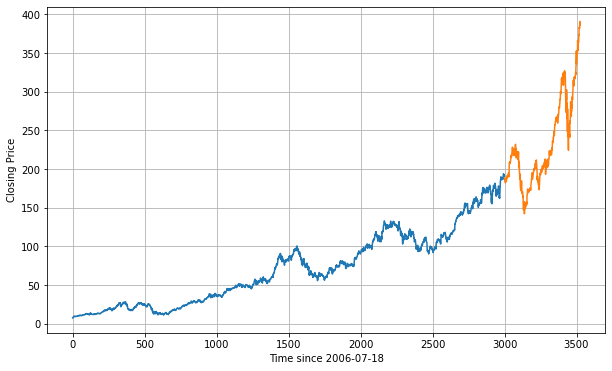

In [31]:
plt.figure(figsize=(10,6))
# blue is training, orange is testing
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)